# Juggling RL project

## Install dependencies

It is also necessary to have ffmpeg software installed, in particular its bin folder in your path : <br>

On Windows : tuto - https://www.wikihow.com/Install-FFmpeg-on-Windows <br>
download - https://www.gyan.dev/ffmpeg/builds/


In [9]:
#!pip install gymnasium
#!pip install keras-rl2
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

""

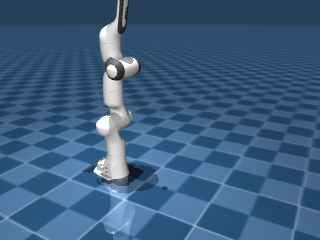

In [2]:
# Make model and data -- https://mujoco.readthedocs.io/en/stable/python.html
model = mujoco.MjModel.from_xml_path("./robot/scene.xml") #
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [3]:
duration = 4  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[1]=-0.476
data.ctrl[2]=-2.14
while data.time < duration: #data.time in second (float)
  if int(data.time*1000) % 1000 == 0: print(data.time)
  if int(data.time*1000) % 100 == 0: print(data.xpos[8])
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

0.0
[0. 0. 0.]
[0.33   0.     1.4902]
[0.33   0.     1.4604]
[0.33   0.     1.4106]
[0.33   0.     1.3408]
[0.33  0.    1.251]
[0.33   0.     1.1412]
[0.33   0.     1.0114]
[0.33   0.     0.8616]
[ 0.3264302  -0.00176189  0.73515021]
1.0000000000000007
[ 0.32315254 -0.00160468  0.73753356]
[ 0.32277896 -0.00189816  0.73911723]
[ 0.32277861 -0.00227607  0.74035703]
[ 0.32286545 -0.00266221  0.74151209]
[ 0.32296404 -0.00291441  0.74255997]
[ 0.32306607 -0.00308702  0.74352258]
[ 0.32331723 -0.00320494  0.74439259]
[ 0.32367678 -0.00325719  0.74509458]
[ 0.3239472  -0.00328051  0.7455807 ]
[ 0.32413445 -0.00329683  0.7459023 ]
2.0000000000000013
[ 0.32426047 -0.00330385  0.74611403]


## Monte Carlo method

Possible improvements :
 - Many high policies
 - Add the old best policy to the new list of roll_outs policies to have an increasing reward
 - Stop a roll_out when the ball hits the ground or do not cross the threshold for 4 sec (e.g.)

In [13]:
# inspect allows you to get all the method of a class 
# - useful to understand a library with little documentation
# import inspect
# inspect.getmembers(data, predicate=inspect.ismethod)

# We found out that the position are given among others by data.xpos
# It is a list of list for each body with x, y and z position
# Position of the ball in our model : data.xpos[-1] = data.xpos[8]
# It is probably because we loaded the ball after the juggler in scene.xml

In [4]:
# Format of a trajectory (dur_cycle, ((t1, x1, y1, z1), ..., (tn, xn, yn, zn)))
# Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
# command[0] = 0 if not a cycle
# command[0] > 0 if it is a cycle (then dur_cycle > tn)

expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                 [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                 [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]

def trajectory_to_command(trajectory): # Error if out of range
    pass

def update_arm(command, current_time, command_step):
    #print(round(current_time, 3))
    if ((int(round(current_time * 500))*2) % (int(round(command[0]*500))*2) == 
        int(round(command[1][command_step][0]*500))*2):
        # print(((int(round(current_time * 500))*2) % (int(round(command[0]*500))*2) == 
        # int(round(command[1][command_step][0]*500))*2))
        data.ctrl[1] = command[1][command_step][1]
        data.ctrl[2] = command[1][command_step][2]
        # print(command_step)
        # print(int(round(current_time * 500))*2)
        # print(int(round(command[1][command_step][0]*500))*2)
        # print("duration", int(round(command[0]*500))*2)
        # print("=====")
        command_step = (command_step + 1) % len(command[1])
    #print("in function", command_step)
    return command_step

In [5]:
# Simulate and display video.
def simulation_video(command):
  frames = []
  ball_positions = []
  mujoco.mj_resetData(model, data)  # Reset state and time.
  command_step = 0
  while data.time < duration: #data.time in second (float)
    #if abs(round(data.time) - data.time) < 0.005: print(data.time)
    if int(round(data.time * 1000)) % 1000 == 0: print(f"Computed {int(round(data.time))} out of {duration} seconds")
    if int(round(data.time * 1000)) % 10 == 0: ball_positions.append(data.xpos[-1].copy())
    command_step = update_arm(command, data.time, command_step)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render().copy()
      frames.append(pixels)
    #print(command_step)
  return frames, ball_positions

In [6]:
expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]

In [7]:
command_old = (4, ((0, -0.476, -2.14), (1, -0.3, -1.9), (2, -0.1, -1.8),
               (3, 0.2, -1.5)))

duration = 10  # (seconds)
framerate = 10  # (Hz)
video, ball_positions = simulation_video(expert_command)
media.show_video(video, fps=framerate)

Computed 0 out of 10 seconds
Computed 1 out of 10 seconds
Computed 2 out of 10 seconds
Computed 3 out of 10 seconds
Computed 4 out of 10 seconds
Computed 5 out of 10 seconds
Computed 6 out of 10 seconds
Computed 7 out of 10 seconds
Computed 8 out of 10 seconds
Computed 9 out of 10 seconds


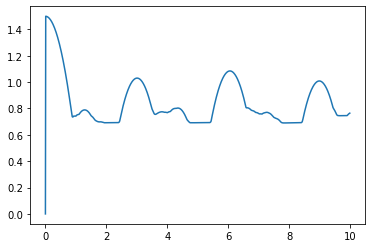

In [8]:
plt.plot([0.010*i for i in range(len(ball_positions))],
        [ball_position[2] for ball_position in ball_positions])

In [9]:
len(video)

101

In [10]:
# Global Variables

PROBA_DUPLICATED = 0.1
PROBA_REMOVED = 0.1
CYCLE_DURATION_SD = 0.05 #second
MAX_CYCLE_DURATION = 5

TIME_SD = 0.02 #second
ACT2_SD = 0.02 #radiant
ACT3_SD = 0.02 #radiant

THRESHOLD = 1 #meter

FRAMERATE = 10 
DURATION = 40

In [11]:
class Monte_Carlo_method():
    def __init__(self, proba_duplicated, proba_removed, cycle_duration_sd, 
                max_cycle_duration, time_sd, act2_sd, act3_sd, threshold, 
                framerate, duration, high_policy_computation="greedy",
                keep_videos=False, verbose=False):
        self.proba_duplicated = proba_duplicated
        self.proba_removed = proba_removed
        self.cycle_duration_sd = cycle_duration_sd
        self.max_cycle_duration = max_cycle_duration
        
        self.time_sd = time_sd
        self.act2_sd = act2_sd
        self.act3_sd = act3_sd
        self.threshold = threshold
        self.framerate = framerate
        self.duration = duration

        self.high_policy_computation = high_policy_computation
        self.keep_videos = keep_videos
        self.verbose = verbose
        self.videos = []


    def learning(self, expert_command, nb_episodes=5, nb_roll_outs=20): 
        """
        Description : Global function with the loop over episodes
        Input :
        - Look above
        Output :
        - The last high policy
        - The best policy of each episode
        """
        high_policy = expert_command

        best_results = [[high_policy, self.reward(self.roll_out(high_policy))]]

        if self.verbose: print("Start learning")
        for id_episode in range(nb_episodes):
            if self.verbose: print(f"Episode {id_episode + 1} / {nb_episodes} |", end="")
            results, best_result = self.episode(high_policy, nb_roll_outs, best_results[-1])
            if self.verbose: print(f" | best reward : {best_result[1]}", end="\n")
            best_results.append(best_result)
            high_policy = self.compute_high_policy(results, best_result)
            # print(" Debug :", end="\n")
            # print(results)
            # print(high_policy)

        return high_policy, best_results
            

    def episode(self, high_policy, nb_roll_outs, last_best_result): 
        """
        Loop over roll_outs
        Output:
        - All the commands of the roll-outs with associated rewards
        - The best command of the episode with associated reward
        """
        best_result = last_best_result
        results = [last_best_result]
        for id_roll_out in range(nb_roll_outs):
            if self.verbose: print(">", end="")
            command = self.sample_policy(high_policy)
            ball_positions = self.roll_out(command)
            roll_out_reward = self.reward(ball_positions)
            if roll_out_reward>best_result[1]:
                best_result = [command, roll_out_reward]
            results.append([command, roll_out_reward])
        return results, best_result


    def roll_out(self, command): 
        """
        Get a deterministic policy from the stochastic policy of the episode
        Input:
        - A command
        Output:
        - The ball positions at each steps
        """
        ball_positions = self.simulation_roll_out(command)
        #print(command)
        return ball_positions

    def reward(self, ball_pos_list): 
        """
        From the list of the ball positions returned by a roll_out, returns the reward
        """
        count_juggling = 1
        below_before = True
        for ball_pos in ball_pos_list:
            if below_before and ball_pos[2] > self.threshold:
                count_juggling += 1
                below_before = False
            if not below_before and ball_pos[2] < self.threshold:
                below_before = True
        
        return count_juggling


    def compute_high_policy(self, results, best_result): 
        # For the moment the length of a command is a hyperparameter
        """
        Merge the roll_out policies using a weighted sum depending 
        on the number of catches (in episode != 0)
        Input:
        - 
        """
        if self.high_policy_computation == "greedy":
            high_policy = best_result[0]

        elif self.high_policy_computation == "mean":
            nb_step = len(results[0][0][1])
            high_policy = [0, [[0, 0, 0] for i in range(nb_step)]]
            sum_reward = 0
            for result in results: # result = [command, reward]
                sum_reward += result[1]
                high_policy[0] += result[0][0] * result[1]
                for step in range(nb_step):
                    high_policy[1][step][0] += result[0][1][step][0] * result[1]
                    high_policy[1][step][1] += result[0][1][step][1] * result[1]
                    high_policy[1][step][2] += result[0][1][step][2] * result[1]
            #normalisation
            for step in range(nb_step):
                high_policy[0] /= sum_reward
                high_policy[1][step][0] /= sum_reward
                high_policy[1][step][1] /= sum_reward
                high_policy[1][step][2] /= sum_reward

        return high_policy


    def sample_policy(self, high_policy):
        # Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
        """
        Sampling of a command = low_policy from the high_policy
        - A command step may be duplicated (not implemented yet)
        - A command step may be removed (not implemented yet)
        - The cycle duration is sampled
        - Each coordinate of the command steps are sampled 
        """
        nb_steps_high_policy = len(high_policy[1])
        command = [0, []]
        duplicated = [0]*nb_steps_high_policy
        removed = [0]*nb_steps_high_policy
        #duplicated = [np.random.Generator.binomial(1, self.proba_duplicated) for i in range(nb_steps_high_policy)]
        #removed = [np.random.Generator.binomial(1, self.proba_removed) for i in range(nb_steps_high_policy)]
        cycle_duration = np.clip(np.random.normal(loc=high_policy[0],scale=self.cycle_duration_sd), 0, self.max_cycle_duration)

        command[0] = cycle_duration
        for id_step in range(nb_steps_high_policy):
            if not removed[id_step]:
                time_previous = -0.05
                for i in range(duplicated[id_step] + 1):
                    
                    step_time = np.clip(
                            np.random.normal(loc=high_policy[1][id_step][0], 
                                             scale=self.time_sd),
                            time_previous+0.05, cycle_duration)
                    time_previous = step_time
                    step_act2 = np.clip(
                            np.random.normal(loc=high_policy[1][id_step][1], 
                                             scale=self.act2_sd),
                            model.actuator_ctrlrange[1][0], model.actuator_ctrlrange[1][1])
                    step_act3 = np.clip(
                            np.random.normal(loc=high_policy[1][id_step][2], 
                                             scale=self.act3_sd),
                            model.actuator_ctrlrange[2][0], model.actuator_ctrlrange[2][1])
                    command[1].append([step_time, step_act2, step_act3])

        return(command)


    def simulation_roll_out(self, command): 
        """
        Or modify the previous one
        """
        ball_positions = []
        if self.keep_videos: frames = []
        mujoco.mj_resetData(model, data)  # Reset state and time.
        command_step = 0
        while data.time < self.duration: #data.time in second (float)
            command_step = update_arm(command, data.time, command_step) #Warning : function outside of the class
            if int(round(data.time * 1000)) % 10 == 0: ball_positions.append(data.xpos[-1].copy())
            mujoco.mj_step(model, data)
            if self.keep_videos:
                if len(frames) < data.time * self.framerate:
                    if self.keep_videos: 
                        renderer.update_scene(data)
                        pixels = renderer.render().copy()
                        frames.append(pixels)
        if self.keep_videos: self.videos.append(frames)
        return ball_positions

In [12]:
method = Monte_Carlo_method(PROBA_DUPLICATED, PROBA_REMOVED, CYCLE_DURATION_SD, 
                MAX_CYCLE_DURATION, TIME_SD, ACT2_SD, ACT3_SD, THRESHOLD, 
                FRAMERATE, DURATION, keep_videos=False, verbose=True)

In [13]:
expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]

In [14]:
results = method.learning(expert_command, nb_episodes=5, nb_roll_outs=80)
# results = method.learning(expert_command, nb_episodes=40, nb_roll_outs=40) with DURATION = 40 => 1h30 very good results 9 - 12 - 14
# PROBA_DUPLICATED = 0.1
# PROBA_REMOVED = 0.1
# CYCLE_DURATION_SD = 0.05 #second
# MAX_CYCLE_DURATION = 5
# TIME_SD = 0.02 #second
# ACT2_SD = 0.02 #radiant
# ACT3_SD = 0.02 #radiant
# THRESHOLD = 1 #meter
# FRAMERATE = 10 
# DURATION = 40

# results = method.learning(expert_command, nb_episodes=20, nb_roll_outs=40) with same hparam and DURATION = 120 => 24m 33 no good results

# results = method.learning(expert_command, nb_episodes=5, nb_roll_outs=20) with DURATION = 40 => 1h30 good results 9 - 13 - 21
# PROBA_DUPLICATED = 0.1
# PROBA_REMOVED = 0.1
# CYCLE_DURATION_SD = 0.05 #second
# MAX_CYCLE_DURATION = 5
# TIME_SD = 0.02 #second
# ACT2_SD = 0.02 #radiant
# ACT3_SD = 0.02 #radiant
# THRESHOLD = 1 #meter
# FRAMERATE = 10 
# DURATION = 40

Start learning
Episode 1 / 5 |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> | best reward : 9
Episode 2 / 5 |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> | best reward : 9
Episode 3 / 5 |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> | best reward : 9
Episode 4 / 5 |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> | best reward : 9
Episode 5 / 5 |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> | best reward : 10


In [15]:
print(results[1][5][0])

[3.0038039506499885, [[0.0, -0.46150705433268435, -2.1340484649093936], [0.927580312438791, -0.41690077870555403, -2.0181238702504323], [0.9883924776410222, -0.2663795264372596, -1.9318478067078273], [1.1056769553762162, -0.19884473692812327, -1.8625121888076985], [1.1893846926311535, -0.08455110039102673, -1.726293015570025], [1.324393784532302, -0.05219408156239288, -1.7347075933553548], [1.5371142003990228, 0.11476158362537926, -1.6880245906831508], [1.6653694696302253, 0.15661117558903936, -1.5760641371064446], [2.3954119232022286, 0.2002520418118522, -1.193532251152977], [2.8187789108807175, -0.4742558047501767, -2.13039780366904]]]


In [16]:
len(method.videos)

0

In [17]:
framerate = 10
duration = 50
video, ball_positions = simulation_video(expert_command)
media.show_video(video, fps=framerate)

Computed 0 out of 50 seconds
Computed 1 out of 50 seconds
Computed 2 out of 50 seconds
Computed 3 out of 50 seconds
Computed 4 out of 50 seconds
Computed 5 out of 50 seconds
Computed 6 out of 50 seconds
Computed 7 out of 50 seconds
Computed 8 out of 50 seconds
Computed 9 out of 50 seconds
Computed 10 out of 50 seconds
Computed 11 out of 50 seconds
Computed 12 out of 50 seconds
Computed 13 out of 50 seconds
Computed 14 out of 50 seconds
Computed 15 out of 50 seconds
Computed 16 out of 50 seconds
Computed 17 out of 50 seconds
Computed 18 out of 50 seconds
Computed 19 out of 50 seconds
Computed 20 out of 50 seconds
Computed 21 out of 50 seconds
Computed 22 out of 50 seconds
Computed 23 out of 50 seconds
Computed 24 out of 50 seconds
Computed 25 out of 50 seconds
Computed 26 out of 50 seconds
Computed 27 out of 50 seconds
Computed 28 out of 50 seconds
Computed 29 out of 50 seconds
Computed 30 out of 50 seconds
Computed 31 out of 50 seconds
Computed 32 out of 50 seconds
Computed 33 out of 5

In [18]:
#media.show_video(method.videos[0], fps=FRAMERATE)

In [19]:
framerate = 10
duration = 40
video, ball_positions = simulation_video(results[1][-1][0])
media.show_video(video, fps=framerate)

Computed 0 out of 40 seconds
Computed 1 out of 40 seconds
Computed 2 out of 40 seconds
Computed 3 out of 40 seconds
Computed 4 out of 40 seconds
Computed 5 out of 40 seconds
Computed 6 out of 40 seconds
Computed 7 out of 40 seconds
Computed 8 out of 40 seconds
Computed 9 out of 40 seconds
Computed 10 out of 40 seconds
Computed 11 out of 40 seconds
Computed 12 out of 40 seconds
Computed 13 out of 40 seconds
Computed 14 out of 40 seconds
Computed 15 out of 40 seconds
Computed 16 out of 40 seconds
Computed 17 out of 40 seconds
Computed 18 out of 40 seconds
Computed 19 out of 40 seconds
Computed 20 out of 40 seconds
Computed 21 out of 40 seconds
Computed 22 out of 40 seconds
Computed 23 out of 40 seconds
Computed 24 out of 40 seconds
Computed 25 out of 40 seconds
Computed 26 out of 40 seconds
Computed 27 out of 40 seconds
Computed 28 out of 40 seconds
Computed 29 out of 40 seconds
Computed 30 out of 40 seconds
Computed 31 out of 40 seconds
Computed 32 out of 40 seconds
Computed 33 out of 4

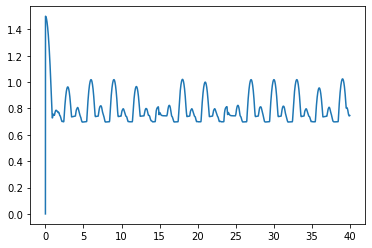

In [20]:
plt.plot([0.010*i for i in range(len(ball_positions))],
        [ball_position[2] for ball_position in ball_positions])

In [21]:
# reward : 14
# [2.9906284605534768,
#  [[0.0, -0.47180170533149735, -2.168891060316549],
#   [0.8985671667369332, -0.37332881003082796, -2.051618906385198],
#   [1.0277461314752672, -0.31037600227516815, -1.9645179934002746],
#   [1.1372847711062044, -0.22909214457850485, -1.869992314817694],
#   [1.1970237680047788, -0.12334695862375639, -1.7356114428732097],
#   [1.2679650843866903, -0.0643698098095597, -1.7051340987529255],
#   [1.5324907464751094, 0.09017186656685039, -1.7016906383799262],
#   [1.7057230592639008, 0.12345298885731838, -1.6130011264106086],
#   [2.405328491323675, 0.18206549335063488, -1.1748763335603822],
#   [2.7803716680190664, -0.45797653906366015, -2.138527010674761]]]